5.031.022-5, Guido Dinello

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
DELTA = '\u0394'	
sns.set_theme(palette="bright")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ejercicio 1 : Clustering
sobre Mall_Customers.csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
mall_df = pd.read_csv('Mall_Customers.csv')

#### 1. Grafico 5 clusters. Annual Income en funcion de Spending Score 

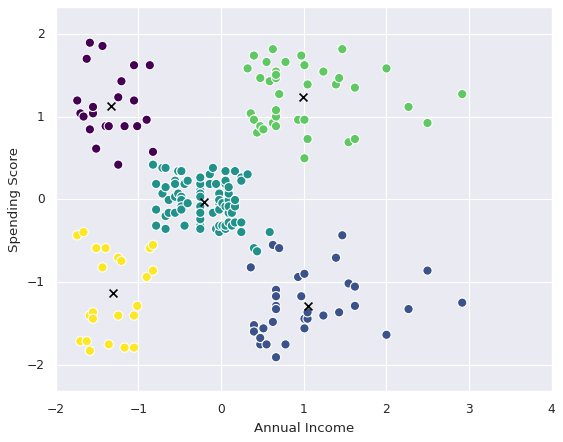

In [ ]:
X = mall_df[['Annual Income (k$)','Spending Score (1-100)']]

# estandarizado
scaler = StandardScaler()
X = scaler.fit_transform(X)

# k-medias
km5 = KMeans(init="k-means++", n_clusters=5, n_init=25)
y_kmeans = km5.fit_predict(X)


fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
# puntos
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=70)
# centroides
centers = km5.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='black', s=50);
# ejes
ax.axis('equal')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')

plt.show()

#### 2.  Grafico Variacion Total en funcion del numero de clusters

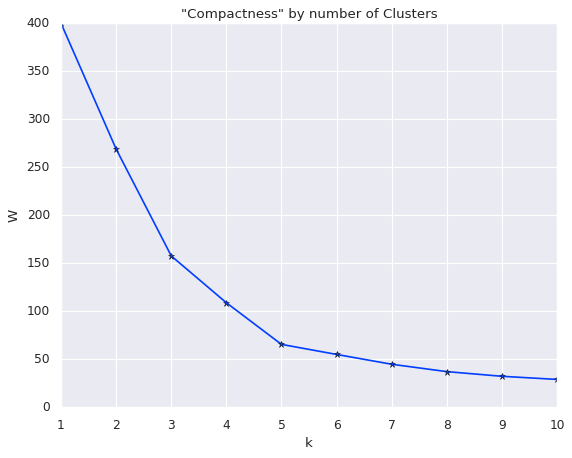

In [ ]:
# W vs k con 1 a 10 clusters
inertias = []
centroids = []
Ks = range(1,11)
for k in Ks:
    kmeanModel = KMeans(n_clusters=k, init="k-means++", n_init=25).fit(X)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)
    centroids.append(kmeanModel.cluster_centers_)

plt.plot(Ks, inertias, 'b*-')
plt.xlabel('k')
plt.ylabel('W')
plt.title('"Compactness" by number of Clusters')
plt.show()

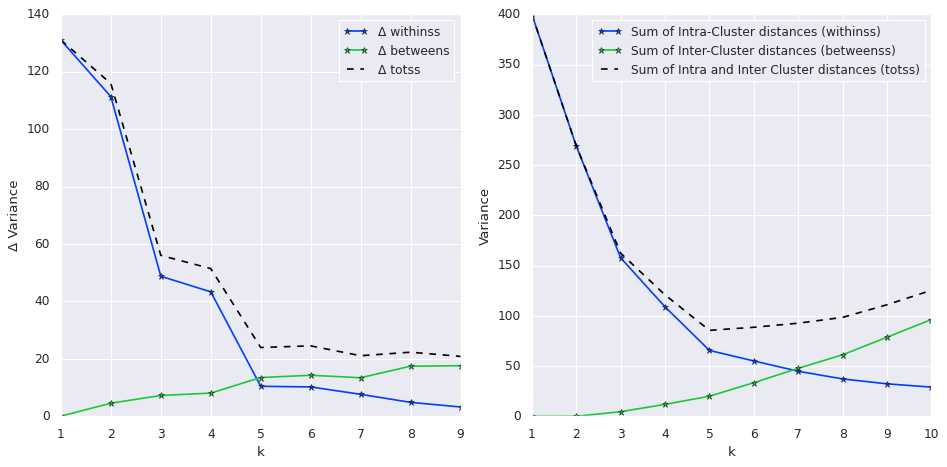

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

deltasW = []
ant = 400
# intra cluster deltas
for sig in inertias[1:]:
  deltasW.append(np.abs(ant-sig))
  ant = sig

# inter cluster
deltasI = []
inters = []
eucl_dist = lambda x1,x2,y1,y2: np.sqrt((x1-x2)**2 + (y1-y2)**2)
from itertools import combinations
# para todos los centroides de un modelo
for model_centroids in centroids:
  inter = 0
  # calcular la distancia entre pares de centroides
  for mu1, mu2 in combinations(model_centroids, 2):
    inter += eucl_dist(mu1[0],mu2[0],mu1[0],mu2[0])
  inters.append(inter)

# inter cluster deltas
ant = 0
for sig in inters[1:]:
  deltasI.append(np.abs(sig-ant))
  ant = sig

deltas_sum = [w+i for w,i in zip(deltasW,deltasI)]

# grafico de los deltas
ax1.plot(range(1,10), deltasW, 'b*-')
ax1.plot(range(1,10), deltasI, 'g*-')
ax1.plot(range(1,10), deltas_sum, color='black', linestyle='dashed')
ax1.set_xlabel('k')
ax1.set_ylabel(f"{DELTA} Variance")
ax1.legend(labels=[f"{DELTA} withinss",f"{DELTA} betweens",f"{DELTA} totss"])

sum = [w+i for w,i in zip(inertias,inters)]

# grafico
ax2.plot(Ks, inertias, 'b*-')
ax2.plot(Ks, inters, 'g*-')
ax2.plot(Ks, sum, color='black', linestyle='dashed')
ax2.set_xlabel('k')
ax2.set_ylabel(f"Variance")
ax2.legend(labels=["Sum of Intra-Cluster distances (withinss)","Sum of Inter-Cluster distances (betweenss)","Sum of Intra and Inter Cluster distances (totss)"])

fig.tight_layout()

Visualmente podemos ver que al utilizar 5 clusters es donde alcanzamos el valor k tal que **un incremento del mismo no mejora significativamente la distancia intra-clusters** -grafico 2, el valor absoulto de la pendiente a partir de k=5 es pequeno-, es decir, encontramos el k que nos otorga los **clusters mas compactos** (menor W) **sin excederse en el numero de clusters**, lo que incrementaria la distancia inter-cluster. Esta relacion se puede observar viendo la suma de ambos indicadores -recta punteada-, se ve que **k=5 es quien minimza esta relacion**. <br>

Otro forma de verlo es observando la pendiente del grafico 1, al ser  practicamente igual a 0 en el tramo k=5 y k=6, esto nos indica que es donde se alcanza un **punto de inflexion** o "codo" (*elbow*).

###### Chequeo con Libreria

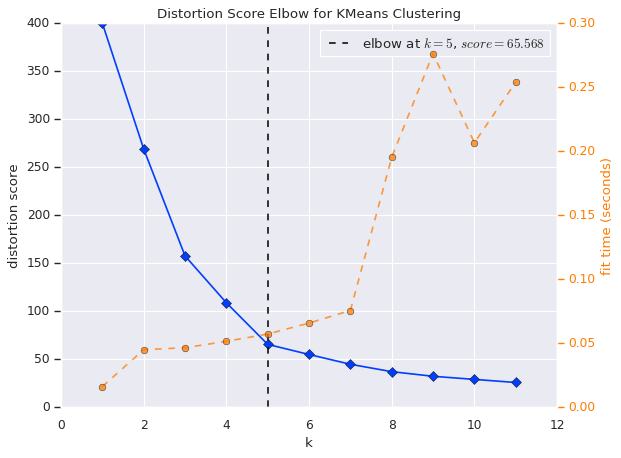

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(init="k-means++", n_init=25)
visualizer = KElbowVisualizer(model, k=(1,12), metric='distortion').fit(X)
visualizer.show()

#### 3. Fuzzy KMeans

In [ ]:
!pip install scikit-fuzzy --upgrade

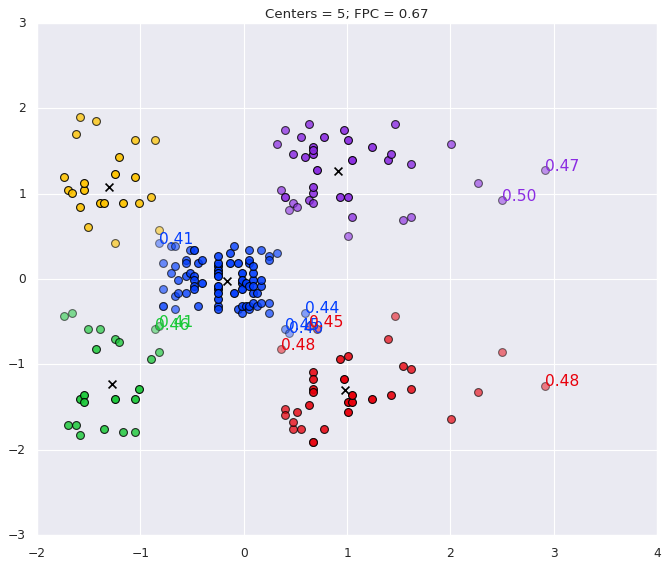

In [ ]:
import skfuzzy as fuzz

K=5
colors = ['b', 'g', 'r', 'm', 'y']
xpts, ypts = X[:,0], X[:,1]

fig1, ax = plt.subplots(figsize=(10, 8))

centers, probabilities, initial_probabilities, distances, jm, p, fpc = fuzz.cluster.cmeans(X.T, K, 2, error=0.005, maxiter=1000, init=None)

# asignacion de puntos al cluster segun la probabilidad
cluster_membership = np.argmax(probabilities, axis=0)

for cluster_index in range(K):
    # indices de los puntos del cluster que estamos graficando
    indexes = [i for i,v in enumerate(cluster_membership == cluster_index) if v == True]
    # scatterplot
    for index in indexes:
      p = probabilities[cluster_index,index]
      c = colors[cluster_index]
      # grafico de puntos, se colorea los puntos segun la probabilidad con alpha=p
      ax.scatter(xpts[index], ypts[index], color=c, alpha=p, s=50, edgecolor='black')
      # si la probabilidad es baja mostrar cuanto
      if p < 0.5 :
        ax.text(xpts[index], ypts[index], f"{p:.2f}", color=c, fontsize=14)

# centroides
for pt in centers:
    ax.scatter(pt[0], pt[1], marker='x', c='black', s=50)

ax.set_title(f'Centers = {K}; FPC = {fpc:.2f}')
plt.show()

#### 4. Algoritmo Expectation Maximization

In [ ]:
from scipy.stats import multivariate_normal

def gaussian_2d_level_curves(data, mus, sigmas, labels):
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)

  # grilla
  x_min, x_max = data.min(axis=1), data.max(axis=1)
  y_min, y_max = data.min(axis=0), data.max(axis=0)
  step=0.1
  x, y = np.mgrid[-20:20:step, -20:20:step]
  pos = np.dstack((x, y))

  # limite de los ejes
  xs, ys = data[:,0], data[:,1]
  ax.axis('equal')
  ax.set_xlim((xs.min()-0.2, xs.max()+0.2))
  ax.set_ylim((ys.min()-0.2, ys.max()+0.2))

  # colores para los clusters
  from matplotlib.cm import Purples, Blues, Greens, Oranges, Reds
  colMaps = [Purples, Blues, Greens, Oranges, Reds]
  for cmap in colMaps:
    cmap.set_under(color='white',alpha=0) 
  
  for mu, sigma, colMap in zip(mus,sigmas,colMaps):
    # curvas de nivel
    rv = multivariate_normal(mu, sigma)
    s = ax.contourf(x, y, rv.pdf(pos), levels=14, antialiased=True, cmap=colMap, vmin=0.2)
    # centroids
    ax.scatter(mu[0], mu[1], c='black', marker='x')

  sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, s=40, palette=['purple','blue','green','orange','red']);

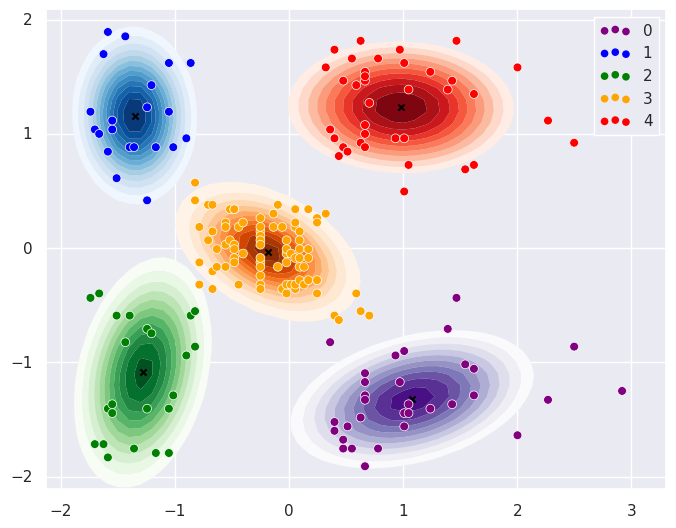

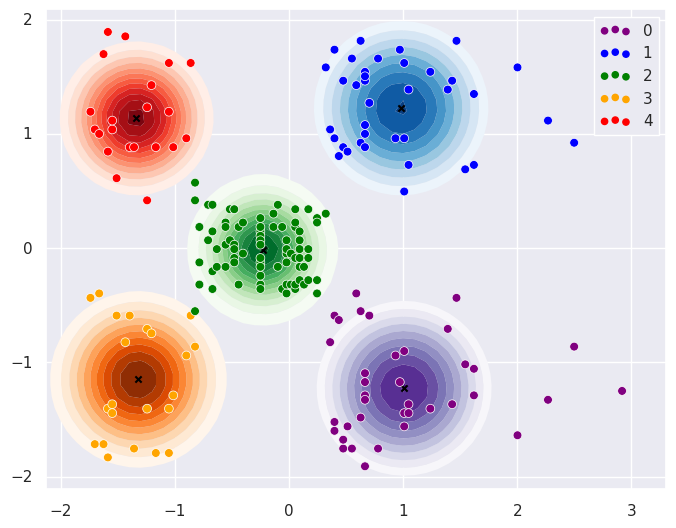

In [ ]:
from sklearn.mixture import GaussianMixture

cov_matrices_types = ['full', 'spherical']
# se prueba con diferentes tipos de matrices de covarianza para modificar la forma de los clusters hallados
for cov_type in cov_matrices_types:
  gmm = GaussianMixture(n_components=5, n_init=25, covariance_type=cov_type).fit(X)
  gaussian_2d_level_curves(X, gmm.means_, gmm.covariances_, gmm.predict(X))


#### 5. Similitudes y Diferencias

  La diferencia tal vez mas evidente entre los clusters hallados por KMeans y EM es la **forma** de los mismos. En cada paso **KMeans**, recalcula los centroides usando la media de los clusters hallados previamente, esto resulta en el hecho de que los **clusters hallados siempre tiendan a ser esfericos**, puesto que el centroide queda en el medio. <br>
  Es por esto que los clusters hallados por KMeans son practicamente identicos a los hallados por GaussianMixture cuando "seteamos" el argumento de tipo de covarianza como *spherical*. <br>
  Por otro lado, como vemos en el resto de los casos, **GMM no tiene problema en identificar clusters con formas elipticas**. <br>
  De todos modos, en nuestro caso en particular, la diferencia entre los clusters hallados es pequeña y corresponde a unos pocos puntos que son "complicados" de segmentar, son aquellos que tambien reciben una probabilidad de pertenencia baja al cluster asignado cuando ejecutamos el algoritmo de fuzzy kmeans. <br>


https://towardsdatascience.com/a-comparison-between-k-means-clustering-and-expectation-maximization-estimation-for-clustering-8c75a1193eb7


 

# Regresion
sobre Credit

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Credit.csv to Credit.csv


In [3]:
credit_df = pd.read_csv('Credit.csv')
credit_df.drop(credit_df.columns[0], axis=1, inplace=True) # remove unnamed column

#### 1. Scatterplot de los pares de variables

In [ ]:
credit_df.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_vars = ["Gender", "Student", "Married", "Ethnicity"]
ohe_vars = ["Gender", "Student", "Married", "Ethnicity_0", "Ethnicity_1"]
num_vars = ["Income", "Limit", "Rating", "Cards", "Age", "Education", "Balance"]

# Dummy Encoding, para eso es el parametro drop='first'
ohe = OneHotEncoder(categories='auto', drop='first',sparse=False)
encoded_credit_data = ohe.fit_transform(credit_df[cat_vars])

# Reconstruyendo el dataframe
encoded_credit_data = np.hstack(( credit_df.drop(columns=cat_vars), encoded_credit_data))
encoded_credit_df = pd.DataFrame(data=encoded_credit_data, columns=num_vars+ohe_vars)

In [ ]:
credit_df.iloc[:2,:]

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903


In [ ]:
encoded_credit_df.iloc[:2,:]

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender,Student,Married,Ethnicity_0,Ethnicity_1
0,14.891,3606.0,283.0,2.0,34.0,11.0,333.0,0.0,0.0,1.0,0.0,1.0
1,106.025,6645.0,483.0,3.0,82.0,15.0,903.0,1.0,1.0,1.0,1.0,0.0


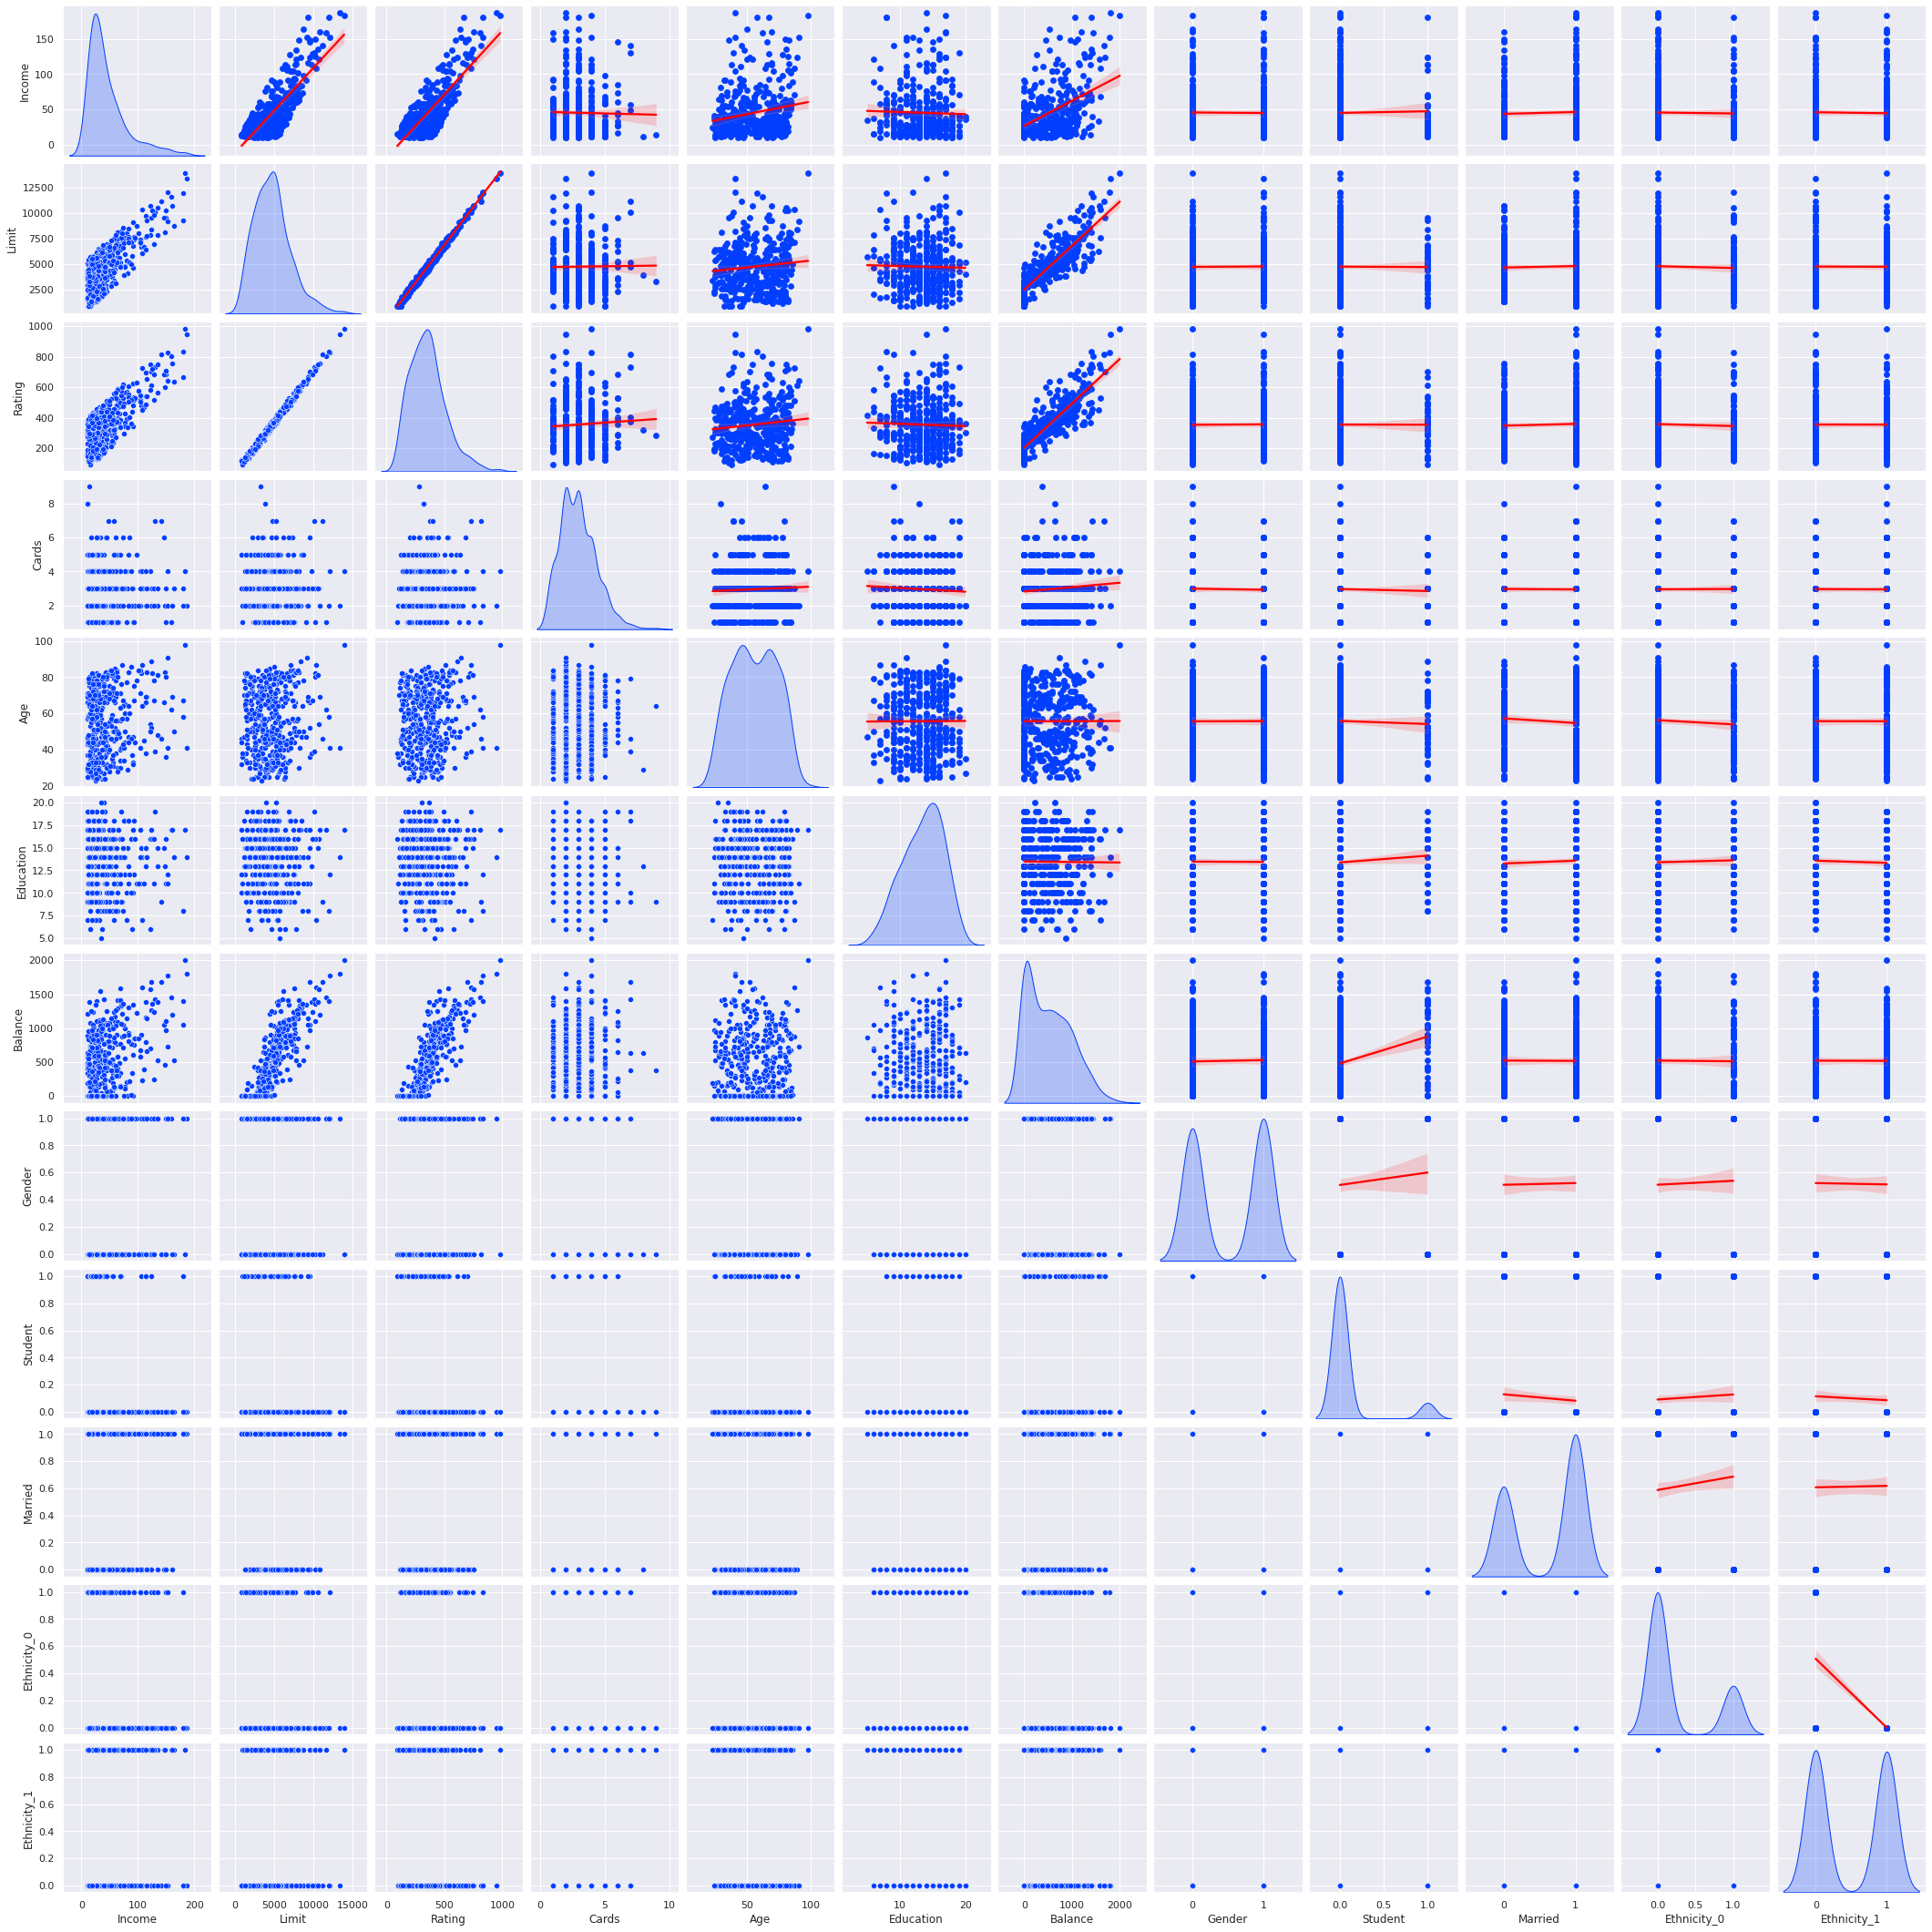

In [ ]:
g = sns.pairplot(data=encoded_credit_df, diag_kind="kde", height=2.5)
g.map_upper(sns.regplot, line_kws={'color':'red'})

Fijandonos en la fila de la variable Rating podemos notar que tiene una alta correlacion tanto con Balance como con Income y **una correlacion practicamente perfecta con la variable Limit**, esto ultimo es un factor decisivo para eliminarla del dataset, pues Rating no va a aportarnos ninguna informacion extra de lo que ya nos aporta Limit. <br>


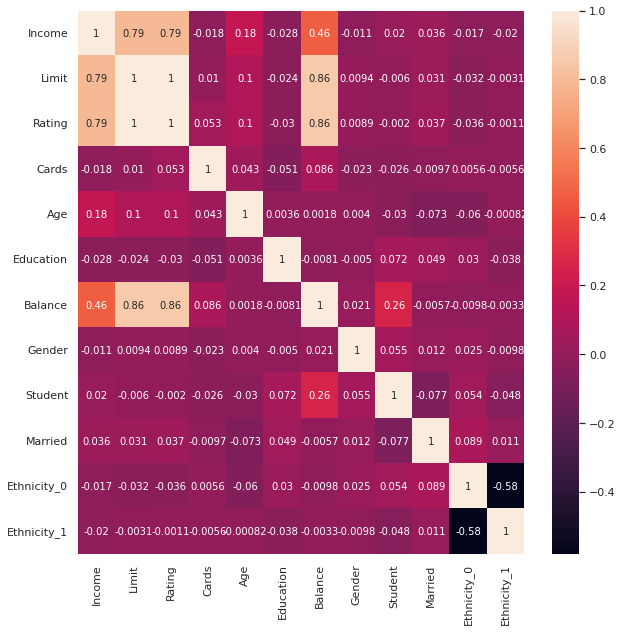

In [ ]:
corr = encoded_credit_df.corr()
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data=corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)

En el grafico de arriba podemos ver que efectivamente **la correlacion entre Limit y Rating es exactamente 1**, por lo que a efectos practicos las podriamos considerar incluso como **la misma variable**, por ende, podriamos **eliminar** cualquiera de la dos **sin perdida de informacion**. <br>
Mas aun, eliminar alguna de las dos es beneficioso para poder interpretar los modelos de regresion lineal, dado que perderia sentido el analisis de los coeficientes puesto que no podriamos ver el cambio en la media de la variable independiente al variar una unidad de cierta variable dependiente **dejando constantes al resto de variables dependientes**.

In [4]:
credit_df.drop(columns="Rating", axis=1, inplace=True)

#### 2. Limit por grupo etnico, por genero y por ambas

In [5]:
import statsmodels.formula.api as smf

# fit models
model_eth =         smf.ols(formula= "Limit ~ Ethnicity"         ,data=credit_df).fit()
model_gen =         smf.ols(formula= "Limit ~ Gender"            ,data=credit_df).fit()
model_interaction = smf.ols(formula= "Limit ~ Ethnicity:Gender"  ,data=credit_df).fit()
model_both =        smf.ols(formula= "Limit ~ Ethnicity + Gender",data=credit_df).fit()

In [ ]:
print(model_eth.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3541
Date:                Sat, 25 Jun 2022   Prob (F-statistic):              0.702
Time:                        00:30:52   Log-Likelihood:                -3664.4
No. Observations:                 400   AIC:                             7335.
Df Residuals:                     397   BIC:                             7347.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4881

Modelo 1: Limit por Ethnicity

\begin{equation}
  Limit = β_{0} + β_{1} * Ethnicity_{i, Asian} + β_{2} * Ethnicity_{i, Caucasian} + ϵ_{i} = 
  \left\{
    \begin{matrix}
      β_{0} + β_{1} + ϵ_{i} \text{ , si la i-esima persona es Asiatica} \\
      β_{0} + β_{2} + ϵ_{i} \text{ , si la i-esima persona es Caucasica} \\
      β_{0} + ϵ_{i} \text{ , si la i-esima persona es Afroamericana}
    \end{matrix}
  \right.
\end{equation}

Entonces tenemos que : <br>
> * $β_{0} = intercept = 4881.5960$ es la media del Limite de la tarjeta de credito para individuos Afroamericanos. <br>
> * Por otro lado, se estima que la diferencia del Limite de la tarjeta de credito entre individuos Asiaticos y Afroamericanos es de $-273.7724$, luego
$β_{0} + β_{1} = 4881.5960 + -273.7724 = 4607,8236$ seria la media del Limite de la tarjeta de credito para los individuos Asiaticos. <br>
> * Analogamente, 
$β_{0} + β_{2} = 4881.5960 + -153.1336 = 4728,4624$ seria la media del Limite de la tarjeta de credito para los individuos Caucasicos. <br>

De todas formas, es necesario aclarar que el **modelo no es estadisticamente significativo** puesto que el p-valor del test F (0.702) es muy grande. <br>
Ademas, como los **p-valores** correspondientes a los coeficientes $β_{1}$ y $β_{2}$ son muy **elevados tambien carece de sentido analizarlos** dado que corresponde aceptar la hipotesis nula de cada test. <br>
\begin{align}
  H_{0} : β_{1} = 0 \\
  H_{0} : β_{2} = 0
\end{align}
Es decir, **no hay una evidencia estadistica significativa de que exista una relacion lineal entre las variables** *Income* y *Ethnicity*.  

https://anestesiar.org/2020/no-lo-dejes-a-medias-diagnostico-del-modelo-de-regresion/ <br>
https://www.pluralsight.com/guides/interpreting-data-using-statistical-models-python <br>
https://networkianos.com/regresion-lineal-multiple/

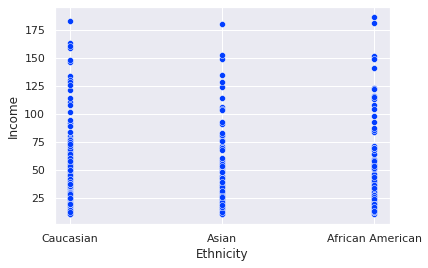

In [ ]:
sns.scatterplot(x=credit_df["Ethnicity"], y=credit_df["Income"])

Era algo esperable dado que **no se cumple el supuesto de linealidad**, donde se asume que debe exisitr una relación lineal entre la variable dependiente y la independiente. <br>
Que esto no se cumpla no es de extrañar al ver el grafico de arriba u observando la cercania a cero de los coeficientes de correlacion que veiamos en el heatmap. <br>

In [ ]:
# chequeo de la interpretacion 
asian = credit_df[(credit_df["Ethnicity"] == "Asian")]["Limit"]
caucasian = credit_df[(credit_df["Ethnicity"] == "Caucasian")]["Limit"]
african_american = credit_df[(credit_df["Ethnicity"] == "African American")]["Limit"]

print(f"asian Limit mean = {asian.mean()}")
print(f"caucasian Limit mean = {caucasian.mean()}")
print(f"african american Limit mean = {african_american.mean()}")

asian Limit mean = 4607.823529411765
caucasian Limit mean = 4728.462311557789
african american Limit mean = 4881.595959595959


In [ ]:
print(model_gen.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03515
Date:                Sat, 25 Jun 2022   Prob (F-statistic):              0.851
Time:                        00:31:02   Log-Likelihood:                -3664.7
No. Observations:                 400   AIC:                             7333.
Df Residuals:                     398   BIC:                             7341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4713.1658    166.349  

Modelo 2: Limit por Gender

\begin{equation}
  Limit = β_{0} + β_{1} * Gender_{i} + ϵ_{i} = 
  \left\{
    \begin{matrix}
      β_{0} + β_{1} + ϵ_{i} \text{ , si la i-esima persona es de sexo Femenino} \\
      β_{0} + ϵ_{i} \text{ , si la i-esima persona es de sexo Masculino} \\
    \end{matrix}
  \right.
\end{equation}

Entonces tenemos que : <br>
> * $β_{0} = intercept = 4713.16580$ es la media del Limite de la tarjeta de credito para individuos de sexo Masculino. <br>
> * Por otro lado, se estima que la diferencia del Limite de la tarjeta de credito entre individuos de un sexo y otro es de 43.3511, luego
$β_{0} + β_{1} = 4713.16580 + 43.3511 = 4756,5169$ seria la media del Limite de la tarjeta de credito para los individuos del sexo Femenino. <br>

En este caso, el p-valor del F-test es menor a 0.05 por lo que podemos considerarlo estadisticamente significativo pero nuestro modelo tampoco consigue explicar la varianza de la variable independiente y esto se traduce en un $R^{2}$ practicamente nulo.
De igual manera, como fue explicado en el primer Modelo, el p-valor tan elevado para la variable Gender hace que su interpretacion carezca de sentido, dado que no podemos afirmar la existencia de una relacion lineal entre las variables *Income* y *Gender*.

In [6]:
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5214
Date:                Tue, 28 Jun 2022   Prob (F-statistic):              0.760
Time:                        22:19:58   Log-Likelihood:                -3663.4
No. Observations:                 400   AIC:                             7339.
Df Residuals:                     394   BIC:                             7363.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Modelo 3: Limit por interaccion Ethnicity-Gender

\begin{equation}
  Limit = β_{0} + β_{1} * Gender_{i,Female} + β_{2} * Ethnicity_{i,Asian} * Gender_{i,Male} + β_{3} * Ethnicity_{i,Caucasian} * Gender_{i,Male} + β_{4} * Ethnicity_{i,Asian} * Gender_{i,Female} + β_{4} * Ethnicity_{i,Caucasian} * Gender_{i,Female} + ϵ_{i}
\end{equation}

En este caso, el **p-valor del estadistico F**, 0.760 tambien es elevado. Por lo tanto, **no podemos rechazar la hipotesis nula del test F**. De igual manera, podemos observar que **ninguno de los terminos de interaccion son estadisticamente significativos**. <br>
En conclusion el modelo de la interaccion de ambas variables tampoco es capaz de predecir la varianza de la variable Limit.

In [ ]:
# podriamos ver que ocurre con ambos por separado
print(model_both.summary())

                            OLS Regression Results                            
Dep. Variable:                  Limit   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2498
Date:                Sat, 25 Jun 2022   Prob (F-statistic):              0.861
Time:                        00:31:07   Log-Likelihood:                -3664.4
No. Observations:                 400   AIC:                             7337.
Df Residuals:                     396   BIC:                             7353.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4857

Modelo 3.1: Limit por Ethnicity y Gender

\begin{equation}
  Limit = β_{0} + β_{1} * Ethnicity_{i,Asian} + β_{2} * Ethnicity_{i,Caucasian} + β_{3} * Gender_{i} + ϵ_{i} = 
  \left\{
    \begin{matrix}
      β_{0} + β_{1} + β_{3} + ϵ_{i} \text{ , si la i-esima persona es Asiatica y de sexo Femenino} \\
      β_{0} + β_{2} + β_{3} + ϵ_{i} \text{ , si la i-esima persona es Caucasica y de sexo Femenino} \\
      β_{0} + β_{3} + ϵ_{i} \text{ , si la i-esima persona es Afroamericana y de sexo Femenino} \\
      β_{0} + β_{1} + ϵ_{i} \text{ , si la i-esima persona es Asiatica y de sexo Masculino} \\
      β_{0} + β_{2} + ϵ_{i} \text{ , si la i-esima persona es Caucasica y de sexo Masculino} \\
      β_{0} + ϵ_{i} \text{ , si la i-esima persona es Afroamericana y de sexo Masculino} \\
    \end{matrix}
  \right.
\end{equation}

Entonces tenemos que : <br>
> * $β_{0} = intercept = 4857.3793$ es la media del Limite de la tarjeta de credito para individuos Afroamericanos y de sexo Masculino. <br>
> * Y con un analisis analogo al realizado en los modelos anteriores, se obtienen el resto de interpretaciones sobre los coeficientes.
\begin{bmatrix}
E  & G & media Limit \\
AA & F &  β_{0} + β_{3} = 4905,3283 \\
A  & F &  β_{0} + β_{1} + β_{3} = 4629,9177 \\
A  & M &  β_{0} + β_{1} = 4581,9687 \\
C  & F &  β_{0} + β_{2} + β_{3} = 4751,8344 \\
C  & M &  β_{0} + β_{2} = 4703,8854 \\
\end{bmatrix}

Nuevamente con un valor de 0.861 para el **p-valor del estadistico F**, no podemos otorgarle una significancia estadistica al modelo. 

>Nota: Los p-valores de los coeficientes tambien siguen siendo mayores al nivel de significancia elegido (0,05) en este modelo. 

https://timeseriesreasoning.com/contents/f-test-for-regression-analysis/  


#### 3. Division del conjunto en training y testing sets

In [ ]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(credit_df, test_size=0.2, random_state=25)
training_df = pd.DataFrame(data=training_data, columns=credit_df.columns)
testing_df = pd.DataFrame(data=testing_data, columns=credit_df.columns)

#### 4. Ajuste del modelo, Balance por Income y Student

Siguiendo la estrategia de codificacion dummy variable para la variable Student, el modelo queda:

\begin{align}
  Balance_{i} ≈ β_{1}*income_{i} + 
  \left\{ 
      \begin{matrix}
          β_{0} + β_{2} \text{ , si la observacion i-esima presenta Student = 1} \\    
          β_{0} \text{ , si la observacion i-esima presenta Student = 0} \\
      \end{matrix}
  \right.
\end{align}


In [ ]:
model_incSt = smf.ols(formula="Balance ~ Income + Student", data=training_df).fit()

In [ ]:
print(model_incSt.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     66.65
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           6.88e-25
Time:                        00:31:12   Log-Likelihood:                -2359.4
No. Observations:                 320   AIC:                             4725.
Df Residuals:                     317   BIC:                             4736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        211.4181     35.488      5.

**Tanto el p-valor del estadistico F como el p-valor asociado a cada coeficiente son lo suficientemente pequeños como para darle significancia a nuestro modelo**. <br>
Analizando los coeficientes podemos interpretar que para estudiantes, el balance medio en su tarjeta de credito es de $β_{0} + β_{1} = 211.4181 + 349.0814 = 560.4995 $ mientras que para no estudiantes es de $211.4181$. Ademas, cada unidad que incrementemos en la variable Income esta asociada con un incremento de $6.1015$ unidades en su balance.

Veamos si agregar un termino de interaccion es beneficioso para el modelo

\begin{align}
  Balance_{i} ≈ β_{0} + β_{1}*Income_{i} + β_{2}*Student_{i} + β_{3}*(Income_{i}*Student_{i})
\end{align}

In [ ]:
model_interaction = smf.ols(formula="Balance ~ Income + Student + Income:Student", data=training_df).fit()

In [ ]:
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     45.34
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           2.14e-24
Time:                        00:31:20   Log-Likelihood:                -2358.3
No. Observations:                 320   AIC:                             4725.
Df Residuals:                     316   BIC:                             4740.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               196.13

Incrementar la complejidad del modelo agregando la interaccion no es beneficioso, pues el porcentaje de varianza explicada por el modelo es practicamente la misma, pasa de 29.6% a 30.1%, y ademas el p-valor del coeficiente de la interaccion (0.138) es muy elevado. 

#### 5. Graficos Balance por Income para Students y no Students

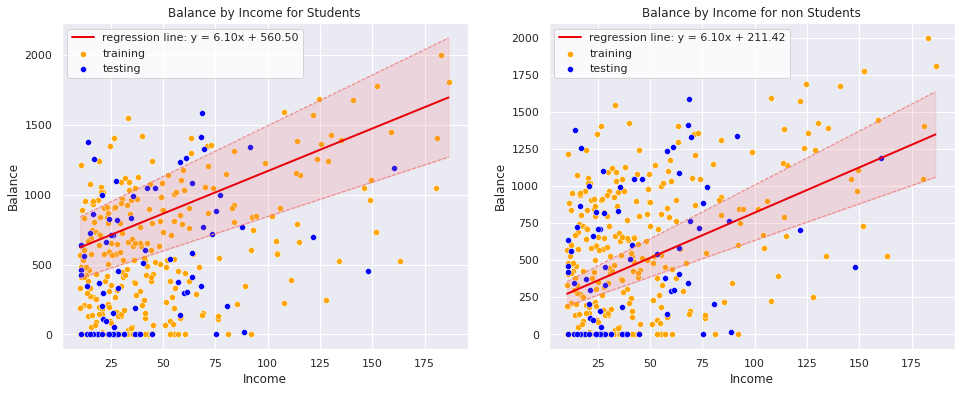

In [ ]:
intercept, coef_st, coef_inc = model_incSt.params

# lineas de regresion
income = credit_df["Income"]
xs = np.arange(income.min(), income.max())
ys = [xs * coef_inc + coef_st + intercept, xs * coef_inc + intercept]

# intervalos de confianza
interval95 = model_incSt.conf_int(alpha=0.05, cols=None)
intercept_lower, coef_st_lower, coef_inc_lower = interval95.iloc[:,0]
intercept_upper, coef_st_upper, coef_inc_upper = interval95.iloc[:,1]
lowers = [intercept_lower + coef_st_lower + coef_inc_lower * xs, intercept_lower + coef_inc_lower * xs]
uppers = [intercept_upper + coef_st_upper + coef_inc_upper * xs, intercept_upper + coef_inc_upper * xs]

# scatterplots
fig, axes = plt.subplots(1, 2, figsize=(16,6))

titles = ["Balance by Income for Students", "Balance by Income for non Students"]
intercepts = [intercept + coef_st, intercept]
for ax,title,intercept,y,lower,upper in zip(axes,titles,intercepts,ys,lowers,uppers):
  ax.set_title(title)
  sns.scatterplot(x=training_data["Income"], y=training_data["Balance"], color='orange', ax=ax)
  sns.scatterplot(x=testing_data["Income"], y=testing_data["Balance"], color='blue', ax=ax)
  ax.legend(loc='upper left', labels=[f"regression line: y = {coef_inc:.2f}x + {intercept:.2f}", "training", "testing"], facecolor='white')

  # intervalos de confianza y linea de regresion
  ax.plot(xs, y, c='r', linewidth=2)
  ax.plot(xs, lower, c='lightcoral', linestyle='dashed', linewidth=1)
  ax.plot(xs, upper, c='lightcoral', linestyle='dashed', linewidth=1)
  ax.fill_between(xs, lower, upper, alpha=0.2, color='lightcoral')

plt.show()

#### 6. Porcentaje de Varianza Explicada por el modelo

In [ ]:
print(model_incSt.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     66.65
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           6.88e-25
Time:                        00:31:30   Log-Likelihood:                -2359.4
No. Observations:                 320   AIC:                             4725.
Df Residuals:                     317   BIC:                             4736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        211.4181     35.488      5.

Como la proporcion de varianza explicada por el modelo es igual al estadistico $ R^2 $. Podemos ver en el cuadro de arriba que el modelo explica un 29.6% de la varianza.

\begin{equation}
  R^{2} = \frac{\text{Variacion Explicada}}{\text{Variacion Total}} =  \frac{\sum_{i=1}^{n} (\hat{y_{i}} - \bar{y})^2 } {\sum_{i=1}^{n} (y_{i} - \bar{y})^2 }
\end{equation}
, donde $y_{i}$ es el i-esimo valor observado, $\hat{y_{i}}$ es el i-esimo valor predecido por el modelo, e $\bar{y}$ es la media.

In [ ]:
y_pred = model_incSt.predict(training_df[["Income","Student"]])
y = training_df["Balance"]
mean = training_df["Balance"].mean()

var_exp = np.sum((y_pred - mean)**2)
var_tot = np.sum((y - mean)**2)
R2 = var_exp / var_tot

print(R2)

0.2960301115527514


In [ ]:
# veamos que pasa en el conjunto de testeo
y_pred = model_incSt.predict(testing_df[["Income","Student"]])
y = testing_df["Balance"]
mean = testing_df["Balance"].mean()

var_exp = np.sum((y_pred - mean)**2)
var_tot = np.sum((y - mean)**2)
R2 = var_exp / var_tot

print(R2)

0.18811094892149088


Resulta que el modelo logra predecir aun menos la varianza de la variable independiente en el conujnto de testeo. Algo esperable en pequeña proporcion o incluso preocupante si la diferencia es mucha pues podria ser un sintoma de *overfitting*.

#### 7. Error Cuadratico Medio del test set


\begin{equation}
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2} 
\end{equation}

In [ ]:
n = testing_data.shape[0]
y = testing_data["Balance"]
y_pred = model_incSt.predict(testing_data[["Income", "Student"]])
mse = (1/n) * np.sum((y - y_pred)**2)
print(mse)

168156.7504562441


In [ ]:
# comparacion con el training set
n = training_data.shape[0]
y = training_data["Balance"]
y_pred = model_incSt.predict(training_data[["Income", "Student"]])
mse = (1/n) * np.sum((y - y_pred)**2)
print(mse)

148547.60388957532


Este caso es extraño, pues el error en el set de testeo es menor que en el de entrenamiento, pero esto puede deberse simplemente a una casualidad causada por la poca cantidad de datos disponibles.

#### 8. Modelo Propuesto

Debido a la colinealidad existente en nuestro conjunto de variables y aprovechando que el numero de variables es menor que el de observaciones vamos a seguir una estrategia de *Backward Selection*, de la siguiente forma:


> 0. Definimos un *threshold*.
> 1. Comenzamos con un modelo compuesto por todas las variables, *Full Model*.
> 2. Removemos la variable menos significativa.
> 3. Repetimos el paso 2 hasta que alcanzemos una cierta condicion de parada o no tengamos mas variables en el modelo.

Consideraremos a una variable como la menos significativa cuando su p-valor sea mayor que el del resto de variables del modelo.
Definimos como regla de parada, que todas las variables del modelo tengan un p-valor menor al threshold.

Eligiremos un threshold de 0.05, lo que luego podriamos traducir en que para cualquier variable de nuestro modelo, la probabilidad de que esta no tenga efecto -es decir, que los resultados obtenidos fueron casualidad- en la variable dependiente sera menor al 5% 

https://quantifyinghealth.com/stepwise-selection/

In [ ]:
training_data.iloc[:3,:]

,Income,Limit,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
368,89.000,5759,3,37,6,Female,No,No,Caucasian,345
37,30.007,6481,2,69,9,Female,No,Yes,Caucasian,1093
284,14.711,2047,2,67,6,Male,No,Yes,Caucasian,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_vars = ["Gender", "Student", "Married", "Ethnicity"]
ohe_vars = ["Gender", "Student", "Married", "Ethnicity_0", "Ethnicity_1"]
num_vars = ["Income", "Limit", "Cards", "Age", "Education"]

# Dummy Encoding
ohe = OneHotEncoder(categories='auto', drop='first',sparse=False)
encoded_training_data = ohe.fit_transform(training_data[cat_vars])
encoded_testing_data = ohe.fit_transform(testing_data[cat_vars])

# Reconstruimos los dataframes
encoded_training_data = np.hstack(( training_data.drop(columns=cat_vars+["Balance"]), encoded_training_data))
encoded_training_df = pd.DataFrame(data=encoded_training_data, columns=num_vars+ohe_vars)

encoded_testing_data = np.hstack(( testing_data.drop(columns=cat_vars+["Balance"]), encoded_testing_data))
encoded_testing_df = pd.DataFrame(data=encoded_testing_data, columns=num_vars+ohe_vars)

In [ ]:
encoded_training_df.iloc[:3,:]

,Income,Limit,Cards,Age,Education,Gender,Student,Married,Ethnicity_0,Ethnicity_1
0,89.000,5759.0,3.0,37.0,6.0,1.0,0.0,0.0,0.0,1.0
1,30.007,6481.0,2.0,69.0,9.0,1.0,0.0,1.0,0.0,1.0
2,14.711,2047.0,2.0,67.0,6.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
import statsmodels.api as sm 

threshold = 0.05

y_train = training_data["Balance"].values.reshape(320,1)

variables = ["const"]+num_vars+ohe_vars
X_train = encoded_training_df
# OLS no agrega el intercepto por defecto
X_train = sm.add_constant(X_train)

while True:
  # entrenamos al modelo con las variables del paso
  X_train = X_train[variables]
  model = sm.OLS(endog = y_train, exog = X_train).fit()

  # hallamos la variable con mayor p-valor
  less_significative = variables[np.argmax(model.pvalues)]
  # si el mayor p-valor es menor al threshold terminamos
  if model.pvalues[less_significative] < threshold: 
    print("Optimal Model p-values:")
    print(model.pvalues)
    break
  
  # sino removemos la variable menos significativa
  print(f"Removed variable {less_significative} from model with a p-value = {model.pvalues[less_significative]}")
  variables.remove(less_significative)



Removed variable Ethnicity_0 from model with a p-value = 0.8806566253668182
Removed variable Ethnicity_1 from model with a p-value = 0.8561372291918212
Removed variable Gender from model with a p-value = 0.7588250871669401
Removed variable Married from model with a p-value = 0.7489064511460305
Removed variable Education from model with a p-value = 0.18533234055145478
Removed variable Age from model with a p-value = 0.08791745691789896
Optimal Model:
const       3.581168e-88
Income      4.390304e-93
Limit      6.391232e-186
Cards       5.821883e-09
Student     7.312793e-71
dtype: float64


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1604.
Date:                Sat, 25 Jun 2022   Prob (F-statistic):          5.36e-208
Time:                        00:44:12   Log-Likelihood:                -1925.7
No. Observations:                 320   AIC:                             3861.
Df Residuals:                     315   BIC:                             3880.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -501.5534     17.785    -28.200      0.0

Finalmente obtuvimos el modelo : <br>

\begin{align}
  Balance_{i} = β_{0} + β_{1}*Income_{i} + β_{2}*Limit_{i} + β_{3}*Cards_{i} + β_{4}*Student_{i,yes} + ϵ_{i}
\end{align}

Que logra explicar un 95.3% de la varianza.

#### 9. Error Cuadratico Medio sobre el testing set del nuevo modelo

In [ ]:
n = testing_data.shape[0]
y = testing_data["Balance"]
x = encoded_testing_df[["Income", "Limit", "Cards", "Student"]]
x = sm.add_constant(x)
y_pred = model.predict(exog=x)
mse = (1/n) * np.sum((y - y_pred)**2)
print(mse)

42395.2860905628


Con este modelo obtuvimos un error casi 4 veces menor : 
\begin{align}
\frac{168156.75}{42395.29} = 3,97
\end{align}

In [ ]:
# comparacion con el training set
n = training_data.shape[0]
y = training_data["Balance"]
x = encoded_training_df[["Income", "Limit", "Cards", "Student"]]
x = sm.add_constant(x)
y_pred = model.predict(exog=x)
mse = (1/n) * np.sum((y - y_pred)**2)
print(mse)

323987.96882183827


Otra vez obtenemos este resultado anomalo de menor error en el set de testeo. Pero lo mas probable es que sea una **combinacion** de un **pequeño tamaño de la muestra de testeo** sumado a cierta **"suerte" en la separacion de los datos**.
Probablemente esta diferencia **desapareciera** si volvemos a repetir el entrenamiento del modelo con una **nueva separacion aleatoria** de los datos o usando alguno de los metodos ideados justamente para este tipo de casos, como lo son cualquiera de las variaciones de la tecnica **Validacion Cruzada**.

